# Electron Population

In [1]:
from matplotlib.colors import SymLogNorm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates.sky_coordinate import SkyCoord
import astropy.units as u
from astropy.cosmology import Planck15 as cosmo
from astropy import constants as const
from astropy.wcs import WCS
from ClusterModel import model
from ClusterModel import model_modpar
from ClusterModel import model_tools

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

In [2]:
clust = model.Cluster(name='Coma', 
                      redshift=0.023, M500=7e14*u.Msun, 
                      cosmology=cosmo, silent=False, 
                      output_dir='/home/astrogamma/Project/Output/TestClusterModel')


                 __  __ ___ ___   _   ___   ___                 
                |  \/  |_ _/ __| /_\ |   \ / _ \                
                | |\/| || | (__ / _ \| |) | (_) |               
                |_|  |_|___\___/_/ \_\___/ \___/                
 Modeling the Intra Cluster Atmosphere for Diverse Observations 
----------------------------------------------------------------
                                                                
Setting gNFW Planck coll. (2013) UPP.


# Models for Protons and Thermal Component

In [3]:
#----- Some parameters that can be set at when defining the cluster
clust.coord = SkyCoord("194.953d  27.9806d", frame="icrs", unit="deg")

#----- Define the relevant ICM model (available models are defined in model_modpar.py)

# Density profile of the target thermal gas
clust.density_gas_model = {'name':'beta', 'n_0':3e-3*u.cm**-3, 'beta':2.0/3, 'r_c':290*u.kpc}

# Pressure profile of the target thermal gas
clust.pressure_gas_model = {'name':'GNFW', 'P_0':2.2e-2*u.keV/u.cm**3, 'c500':2.9, 'a':1.8, 'b':3.1, 'c':0.0}

# Set the cosmic ray density profile to the same shape as the thermal gas density
clust.set_density_crp_isodens_scal_param()

# Cosmic ray proton spectrum
clust.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.3}

# Cosmic ray proton normalization
clust.X_cr_E = {'X':0.01, 'R_norm':clust.R500} # X is the CRp/thermal energy ratio, normalized within R_norm

Setting coord value
Setting density_gas_model value
Fixing: R500
Setting pressure_gas_model value
Fixing: R500
Setting spectrum_crp_model value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value


# Primary Electron Population
Set index = 3.81371533e+00, obtained from the Coma data fit 

In [70]:

clust.spectrum_cre1_model = {'name':  'PowerLaw', 'Index': 3.81371533}
                             #2.3}


## For density you can just make the same as protons --> set it equal to the thermal gas 
clust.density_cre1_model = {'name': 'beta', 'n_0':3e-3*u.cm**-3, 'beta':2.0/3, 'r_c':290*u.kpc}

#pull out some random min and max energies
Eemin = (const.m_e *const.c**2).to('GeV')
#clust.Epmin 
Eemax = clust.Epmax

Getting the maximal proton energy


## Functions
Set norm = 2.07162116e-14 , obtained from the Coma data fit 

In [71]:
## Just use the avalialble generic functions

clust.density_cre1_model['n_0'] = 1.0 *u.adu

def get_normed_density_cre1_profile(cl = clust, rad = np.logspace(0,4,100)*u.kpc):
    
   # rad = model_tools.check_qarray(rad, unit = 'kpc')
    nr = cl._get_generic_profile(rad, cl.density_cre1_model)
    nr[rad > cl._R_truncation] *= 0 
    
    return rad, nr.to('adu')


def get_normed_spectrum_cre1(cl = clust , en = np.logspace(-2,7,100)*u.GeV): 
    
    se = cl._get_generic_spectrum(en, cl.spectrum_cre1_model)
    se[en >Eemax] *= 0
    se[en <Eemin] *= 0
    
    return en, se*u.adu



A = (2.07162116e-14)/u.GeV/u.cm**3
#1/u.GeV/u.cm**3

def cre1_2d(cl = clust, en= np.logspace(-2,7,100)*u.GeV, rd =np.logspace(0,4,100)*u.kpc):
    
    #norm
    #r = norm_electrons(clust)
    #norm_electrons(cl)
    #spatial
    rad, fd = get_normed_density_cre1_profile(cl, rd)
    fd2 = model_tools.replicate_array(fd.to_value('adu'), len(en), T = False )
    #energy
    eng, fe = get_normed_spectrum_cre1(cl, en)
    fe2 = model_tools.replicate_array(fe.to_value('adu'), len(rd), T = True )
    
    spectrum= A*fd2*fe2
     
    return spectrum.to('GeV-1 cm-3')



def density_cre1_profile(rad = np.logspace(0,4,100)*u.kpc, Emin = None, Emax = None):
    
    if Emin is None:
        Emin = (const.m_e*const.c**2).to('GeV')
    if Emax is None:
        Emax = clust._Epmax
    
    #Define energy range
    eng = model_tools.sampling_array(Emin, Emax,NptPd = clust._Npt_per_decade_integ, unit = True)
    
    #2D differntial spectrum
    dN_dEdV = cre1_2d(clust, eng, rad)
    
    #Integrate the diffferential spectrum 
    prof = (model_tools.trapz_loglog(dN_dEdV, eng, axis = 0)).to('cm-3')
    
    return rad, prof 


def cre1_spectrum(energy=np.logspace(-2,7,100)*u.GeV, Rmax=None):
    
    energy = model_tools.check_qarray(energy, unit='GeV')
    if Rmax is None:
        Rmax = clust.R500
                
    # Define the radius for integration
    rmin = np.amin([clust.Rmin.to_value('kpc'), Rmax.to_value('kpc')/10])*u.kpc 
    rad = model_tools.sampling_array(rmin, Rmax, NptPd= clust._Npt_per_decade_integ, unit=True)

    if np.amax(rad) > clust.R_truncation:
        rad = rad.insert(0, clust.R_truncation)
        rad.sort()

    # the differential spectrum/profile
    dN_dEdV = cre1_2d(clust, energy, rad)
        
    # Integrate
    spectrum = model_tools.trapz_loglog(4*np.pi*rad**2 * dN_dEdV, rad)

    return energy, spectrum.to('GeV-1')


# Plots

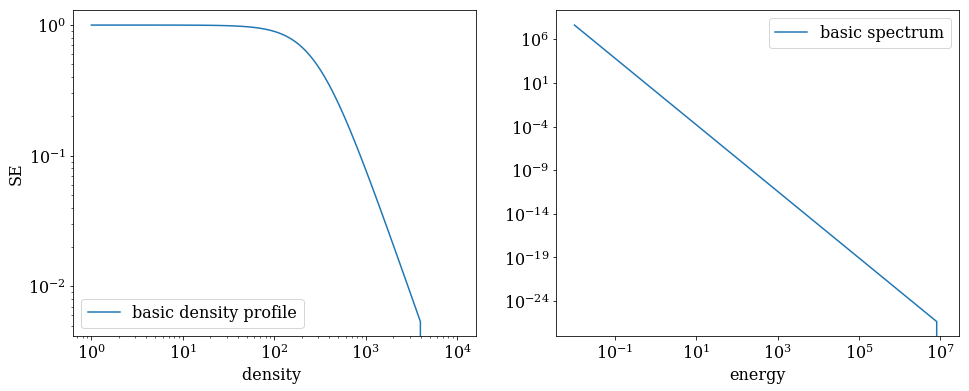

In [72]:
radius=np.logspace(0,4,100)*u.kpc
energy=np.logspace(-2,7,100)*u.GeV

# The simplest plots: density profile and spectrum
plt.figure(figsize=(15,6))
plt.subplot(121)

a ,b = get_normed_density_cre1_profile(clust, radius)
plt.loglog(a,b, label='basic density profile')

plt.xlabel('density ')
plt.ylabel('SE')
plt.legend()


plt.subplot(122)
c, d = get_normed_spectrum_cre1(clust,energy)
plt.loglog(c,d,label = 'basic spectrum')
plt.xlabel('energy')
plt.legend()

Getting R500 value
Getting Rmin value
Getting R_truncation value


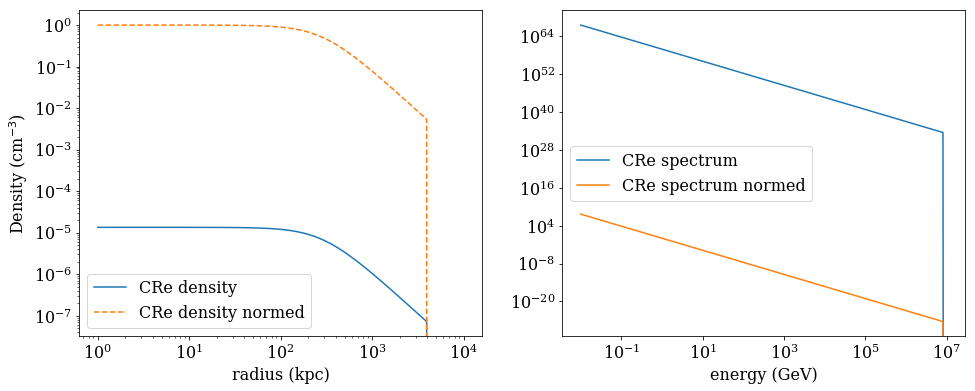

In [73]:
plt.figure(figsize=(15,6))
plt.subplot(121)

r, n_cre_r = density_cre1_profile()
plt.loglog(r, n_cre_r, label='CRe density ')
r, n_cre_r2 = get_normed_density_cre1_profile()
plt.loglog(r, n_cre_r2, '--', label='CRe density normed')

plt.xlabel('radius (kpc)')
plt.ylabel('Density (cm$^{-3}$)')
plt.legend()


plt.subplot(122)
e, n_cre_rs = cre1_spectrum()
plt.loglog(e, n_cre_rs,  label='CRe spectrum')
e, n_cre_rs2 = get_normed_spectrum_cre1()
plt.loglog(e, n_cre_rs2, label = 'CRe spectrum normed')
plt.xlabel('energy (GeV)')

plt.legend()

## Total Energy stored in CRe

In [74]:
#Energy in spectrum
eng = model_tools.sampling_array(Eemin , Eemax, NptPd=clust._Npt_per_decade_integ, unit=True)

#eng, Fe = get_normed_spectrum_cre1(clust, eng)
#Integ_e = model_tools.trapz_loglog( eng* Fe.to_value('adu'), eng)


eng, Fe = cre1_spectrum(eng)
Integ_e = model_tools.trapz_loglog( eng* Fe.to_value('GeV**-1'), eng)
Integ_e

Getting R500 value
Getting Rmin value
Getting R_truncation value


<Quantity 3.22439877e+65 GeV2>

In [75]:
#PRoton energy

eng, Fp = clust.get_crp_spectrum()
Integ_p = model_tools.trapz_loglog( eng* Fp.to_value('GeV**-1'), eng)
Integ_p


<Quantity 1.75836924e+64 GeV2>

In [77]:
##FRaction
Fr_e_p = Integ_e/Integ_p
Fr_e_p

<Quantity 18.33743843>

## Check with Sync

In [78]:
from ClusterModel.ClusterTools import cluster_electron_emission as emi


def rate_sync(energy = np.logspace(-9,-2,100)*u.eV, radius = np.logspace(0,4,100)*u.kpc ):
    
    #Get Magnetic field
    radius, B = clust.get_magfield_profile(radius)
    
    #Define Je: 
    def Je2(rad, eng): return cre1_2d(clust, eng*u.GeV, rad*u.kpc).to_value('GeV-1 cm-3').T


    #rad*u.kpc
    
    
    #Use the class
    model =  emi.ClusterElectronEmission (Je = Je2,Eemin=(const.m_e*const.c**2).to('GeV'), NptEePd=clust._Npt_per_decade_integ)
    rate = model.synchrotron( energy, radius_input = radius, B=B).T
    
    return rate.to('GeV-1 cm-3 s-1')

In [79]:
default = clust.get_rate_synchrotron()
dN_dEdVdt = rate_sync()



Text(0.5,1,'Rate for Primary Electrons')

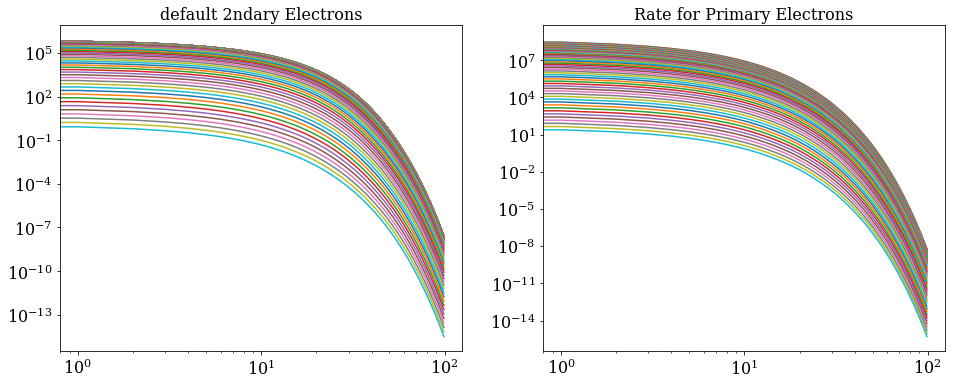

In [81]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.loglog(default)
plt.title("default 2ndary Electrons")

plt.subplot(122)
plt.loglog(dN_dEdVdt)
plt.title("Rate for Primary Electrons")



In [84]:
def sync_spectrum( freq = np.logspace(-3,2,100)*u.GHz):
    
    '''Uses Primary Electron population via rate_sync() and multiplies the result by the norm
    '''
    
    #Get energy
    #freq = model_tools.check_qarray(freq, unit='GHz')
    energy = (const.h*freq).to('eV')
    
 
    Rmin = clust._Rmin
    
    Rmax = clust._R500
        


    #sample radius
    rad = model_tools.sampling_array(Rmin, Rmax, NptPd = clust._Npt_per_decade_integ, unit = True)
    #Use rate sync to get synchotron rate
   
    dNdEdVdt = rate_sync(energy, rad)
    #integrate spherically
    dNdEdt = model_tools.spherical_integration(dNdEdVdt, rad)
    
    #This gave us luminosity; now get flux 
    dNdEdSdt = dNdEdt / (4*np.pi * clust._D_lum**2)
    
    #Convert to Jy 
    return freq, (dNdEdSdt*energy**2 / freq).to('Jy')



In [83]:
# Radio total flux [Thierbach et al (2003)]:

dat_freq = np.array([30.9,43,73.8,151,326,408,430,608.5,1380,1400,2675,2700,4850])*u.MHz
dat_flux = np.array([49,51,17,7.2,3.81,2.0,2.55,1.2,0.53,0.64,0.11,0.07,0.03])*u.Jy
dat_err  = np.array([10,13,12,0.8,0.03,0.2,0.28,0.3,0.05,0.035,0.03,0.02,0.01])*u.Jy

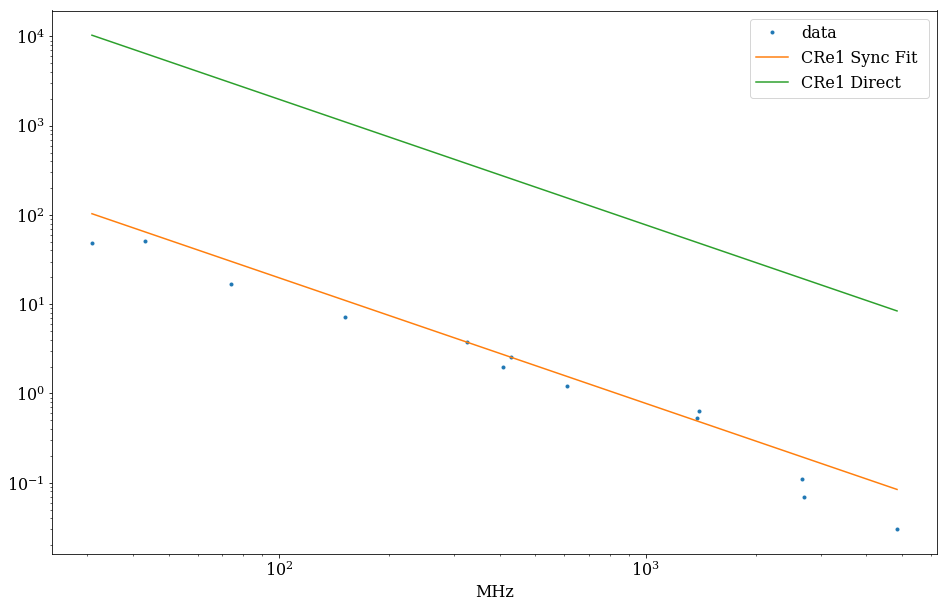

In [88]:

#Primary Electron Population, custom Norm 
dat_freq, spectrum = sync_spectrum(dat_freq)

## SyncFit , norm set 
def syncfit(x):
    return sync_spectrum(x)[1]


trial2 = syncfit(dat_freq)

plt.figure(figsize=(15,10))
##DATA
plt.loglog(dat_freq,dat_flux,".", label = "data")
#PRIMARY Sync Fit
plt.loglog(dat_freq, trial2, "-", label = "CRe1 Sync Fit ")
#Primary, direct
plt.loglog(dat_freq, 100*spectrum , label = "CRe1 Direct")


plt.xlabel(dat_freq.unit)
plt.legend()
plt.show()